In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pylab as plt

import shapely as sh
import pysal as ps
from matplotlib import colors

/Users/aaron/opt/anaconda3/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


### Data last updated on 

In [2]:
covid_by_zips = gp.read_file('./Data/covid_zips.geojson')
covid_by_zips.head()

moran_i_df = covid_by_zips[['zipcode', 'po_name', 'zcta_cum_perc_pos', 'geometry']]
moran_i_df.drop_duplicates(inplace=True)
moran_i_df.reset_index(inplace=True, drop=True)

moran_i_df.crs

/Users/aaron/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Calculate Moran I on zipcode

In [94]:
avg_score_per_zipcode = moran_i_df.groupby('zipcode').agg({'zcta_cum_perc_pos' : 'mean'})
avg_score_per_zipcode.dropna(inplace=True)
avg_score_per_zipcode.reset_index(inplace=True)
avg_score_per_zipcode.rename(columns = {'zcta_cum_perc_pos' : 'percent_mean'}, inplace=True)
avg_score_per_zipcode.head()

avg_score_per_zipcode = pd.merge(avg_score_per_zipcode, moran_i_df, on='zipcode', how='inner')
crs = {'init': 'epsg:4326', 'no_defs': True}
avg_score_per_zipcode = gp.GeoDataFrame(avg_score_per_zipcode, crs=crs, geometry=avg_score_per_zipcode.geometry)
avg_score_per_zipcode.dropna().reset_index(inplace=True, drop=True)

/Users/aaron/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [95]:
avg_score_per_zipcode.zipcode.value_counts()[avg_score_per_zipcode.zipcode.value_counts() > 1]

10004    4
11693    4
10464    3
11370    2
11231    2
10463    2
10035    2
Name: zipcode, dtype: int64

In [108]:
avg_score_per_zipcode = avg_score_per_zipcode[~((avg_score_per_zipcode.zipcode == 10004) | 
(avg_score_per_zipcode.zipcode == 11693) |
(avg_score_per_zipcode.zipcode == 10464) |
(avg_score_per_zipcode.zipcode == 11370) |
(avg_score_per_zipcode.zipcode == 11231) |
(avg_score_per_zipcode.zipcode == 10463) |
(avg_score_per_zipcode.zipcode == 10035))].reset_index( drop=True)

In [109]:
ps.Natural_Breaks(avg_score_per_zipcode.percent_mean, k=10)

             Natural_Breaks             
 
Lower            Upper             Count
         x[i] <= 35.120                8
35.120 < x[i] <= 41.180               10
41.180 < x[i] <= 46.450               25
46.450 < x[i] <= 50.270               18
50.270 < x[i] <= 53.940               22
53.940 < x[i] <= 56.670               15
56.670 < x[i] <= 60.370               24
60.370 < x[i] <= 63.870               26
63.870 < x[i] <= 68.450               16
68.450 < x[i] <= 77.570                6

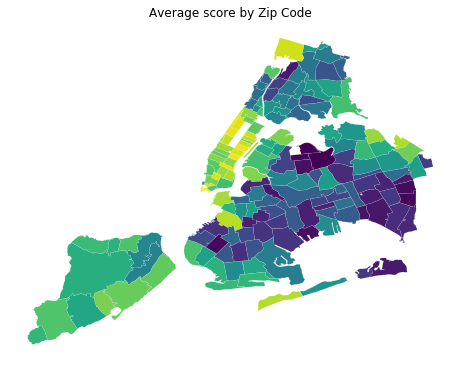

In [110]:
tp10 = ps.Natural_Breaks(avg_score_per_zipcode.percent_mean, k=10)
f, ax = plt.subplots(1, figsize=(8,8))
avg_score_per_zipcode.assign(cl=tp10.yb).plot(column='percent_mean', categorical=True,
                                k=10, cmap='viridis_r', linewidth=0.1, ax=ax, alpha = 1,
                                edgecolor='white')
ax.set_axis_off()
plt.title("Average score by Zip Code")
plt.show()

In [111]:
avg_score_per_zipcode.to_file('./Data/avg_score_per_zipcode.shp')
filepath = './Data/avg_score_per_zipcode.shp'
W = ps.queen_from_shapefile(filepath, idVariable= 'zipcode')
# W = ps.queen_from_shapefile(filepath)
W.transform = 'r'

('WARNING: ', 10044, ' is an island (no neighbors)')
('WARNING: ', 10280, ' is an island (no neighbors)')
('WARNING: ', 11222, ' is an island (no neighbors)')


/Users/aaron/opt/anaconda3/lib/python3.7/site-packages/pysal/weights/weights.py:189: UserWarning: There are 3 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/Users/aaron/opt/anaconda3/lib/python3.7/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 10044, 10280, 11222
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


In [112]:
percent_mean_lag = ps.lag_spatial(W, avg_score_per_zipcode.percent_mean)

In [113]:
tp = avg_score_per_zipcode.percent_mean
b,a = np.polyfit(tp, percent_mean_lag, 1)

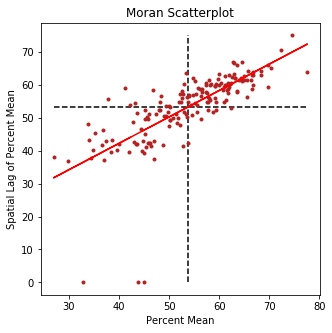

In [114]:
f, ax = plt.subplots(1, figsize=(5, 5))

plt.plot(tp, percent_mean_lag, '.', color='firebrick')

 # dashed vert at mean of pickups
plt.vlines(tp.mean(), percent_mean_lag.min(), percent_mean_lag.max(), linestyle='--')
 # dashed horizontal at mean of lagged pickups
plt.hlines(percent_mean_lag.mean(), tp.min(), tp.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(tp, a + b*tp, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Percent Mean')
plt.xlabel('Percent Mean')
plt.show()

### Calculate Global Moran's I and check if it is statistically significant

In [115]:
I_percent_mean = ps.Moran(avg_score_per_zipcode.percent_mean.values, W, permutations=9999)
I_percent_mean.I, I_percent_mean.p_sim

(0.6763950298135635, 0.0001)

#### The p_values is 0.0001 and the value of Moran's I is statistically significant. This means there is spatial autocorrelation overall in NYC

### Local Indicators of Spatial Association (LISA)

In [116]:
LMo_tp = ps.Moran_Local(avg_score_per_zipcode.percent_mean.values, W, permutations=99999)

sigs = tp[LMo_tp.p_sim <= .001]
W_sigs = percent_mean_lag[LMo_tp.p_sim <= .001]
insigs = tp[LMo_tp.p_sim > .001]
W_insigs = percent_mean_lag[LMo_tp.p_sim > .001]

/Users/aaron/opt/anaconda3/lib/python3.7/site-packages/pysal/esda/moran.py:861: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/Users/aaron/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/aaron/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/aaron/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


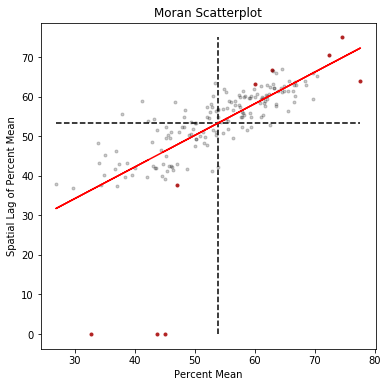

In [117]:
plt.figure(figsize=(6,6))
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
 # dashed vert at mean of pickups
plt.vlines(tp.mean(), percent_mean_lag.min(), percent_mean_lag.max(), linestyle='--')
 # dashed horizontal at mean of lagged pickups
plt.hlines(percent_mean_lag.mean(), tp.min(), tp.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(tp, a + b*tp, 'r')
# plt.text(s='$I = %.3f$' % I_percent_mean.I, x=40010, y=20010, fontsize=18)
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Percent Mean')
plt.xlabel('Percent Mean')
plt.show()

This scatter plot has dark red points that are areas which have statistically significant local Moran's I

* High - High : 1
* Low - High : 2
* Low - Low : 3
* High - Low : 4


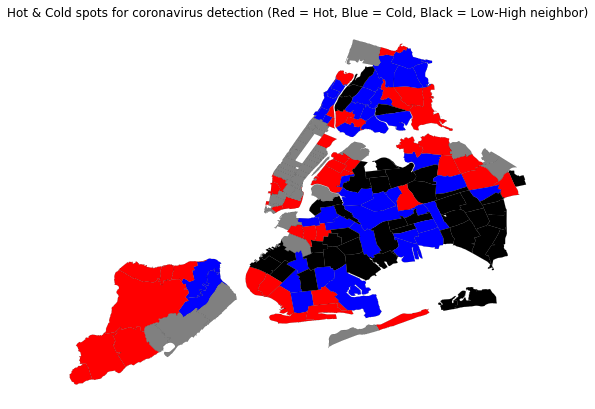

In [118]:
sig = LMo_tp.p_sim <= .001

hotspots = LMo_tp.q == 1 * sig

coldspots = LMo_tp.q==3 * sig

LH = LMo_tp.q==2 * sig

hcmap = colors.ListedColormap(['grey', 'red','blue', 'black'])
hotcold = hotspots*1 + coldspots*2 + LH*3
f, ax = plt.subplots(1, figsize=(9, 9))
avg_score_per_zipcode.assign(cl=hotcold).plot(column='percent_mean', categorical=True, alpha = 1,\
        k=2, cmap=hcmap,linewidth=0.1, ax=ax, \
        edgecolor='black')
ax.set_axis_off()
plt.title("Hot & Cold spots for coronavirus detection (Red = Hot, Blue = Cold, Black = Low-High neighbor)")
plt.show()
